In [1]:
import pandas as pd
import lecilab_behavior_analysis.utils as utils
from pathlib import Path
%load_ext autoreload
%autoreload 2

In [ ]:
# mouse = "mouse2"
# df = utils.load_example_data(mouse)

In [2]:
# load data from cluster
tv_projects = utils.get_server_projects()
print(tv_projects)

['auditory_escape_data', 'cate_task_data', 'COT_cannula_data', 'COT_test_data', 'empty-project_data', 'visual_and_COT_data']


In [3]:
# see the available animals
project_idx = 2
animals = utils.get_animals_in_project(tv_projects[project_idx])
print(animals)

['NUO001', 'NUO002', 'NUO003', 'NUO004', 'NUO005', 'NUO006', 'NUO007', 'NUO008', 'NUO009', 'NUO010', 'NUO011', 'NUO012']


In [17]:
# specify the TV system name
tv_system_name = "village02"

In [4]:
# download the data for a specific animal

# mouse = "mouse2"
# df = utils.load_example_data(mouse)

mouse = "NUO003"
local_path = Path(utils.get_outpath()) / Path(tv_projects[project_idx]) / Path("sessions") / Path(mouse)
# create the directory if it doesn't exist
local_path.mkdir(parents=True, exist_ok=True)
# download the session data
utils.rsync_cluster_data(
    project_name=tv_projects[project_idx],
    file_path="sessions/{}/{}.csv".format(mouse, mouse),
    local_path=str(local_path),
    credentials=utils.get_idibaps_cluster_credentials(),
)

receiving incremental file list

sent 27 bytes  received 78 bytes  70.00 bytes/sec
total size is 189,589,305  speedup is 1,805,612.43


True

In [5]:
# load the data
# mouse = "ACV002"
# local_path = Path(utils.get_outpath()) / Path("visual_and_COT_data") / Path("sessions") / Path(mouse)
df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")

/tmp/ipykernel_2942/2692270050.py:4: DtypeWarning: Columns (13,14,27,28,29,30,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


In [6]:
from lecilab_behavior_analysis import plots
import lecilab_behavior_analysis.utils as utils
import lecilab_behavior_analysis.df_transforms as dft
import matplotlib.pyplot as plt
df["port2_holds"] = df.apply(lambda row: utils.get_trial_port_hold(row, 2), axis=1)
df = dft.add_day_column_to_df(df)
rt_df = dft.get_reaction_times_by_date_df(df)


Text(0.5, 0, '')

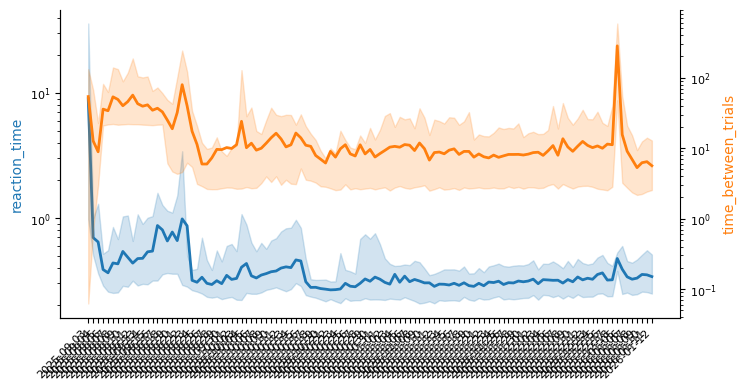

In [7]:
fig_rt, ax_rt = plt.subplots(figsize=(8, 4))
ax_rt = plots.plot_mean_and_cis_by_date(rt_df, item_to_show="reaction_time", group_trials_by="year_month_day", ax=ax_rt, color='tab:blue', ylog=True)
ax_rt = plots.plot_mean_and_cis_by_date(rt_df, item_to_show="time_between_trials", group_trials_by="year_month_day", ax=ax_rt, color='tab:orange', ylog=True)
ax_rt.set_xlabel("")

In [ ]:
# from lecilab_behavior_analysis import plots
# plots.plot_box_usage_by_date(sbu_df)

In [29]:
# sync and load events
local_path = Path(utils.get_outpath()) / Path(tv_projects[project_idx])
utils.rsync_cluster_data(
    project_name=tv_projects[project_idx],
    file_path=tv_system_name,
    local_path=str(local_path),
    credentials=utils.get_idibaps_cluster_credentials(),
)


receiving incremental file list
village02/
village02/deleted_sessions.csv
village02/events.csv
village02/sessions_summary.csv
village02/sound_calibration.csv
village02/subjects.csv
village02/temperatures.csv
village02/water_calibration.csv
village02/old_events/
village02/old_events/events_20250912_090534.csv
village02/old_events/events_20250923_225229.csv
village02/old_events/events_20251004_221207.csv
village02/old_events/events_20251020_163027.csv
village02/old_events/events_20251112_072056.csv
village02/old_events/events_20251205_060521.csv

sent 287 bytes  received 1,786,332 bytes  510,462.57 bytes/sec
total size is 26,140,952  speedup is 14.63


True

In [36]:
events_df = utils.load_all_events(events_subfolder_location=tv_projects[project_idx] + "/" + tv_system_name)

In [37]:
events_df

,date,type,subject,description
0,2025-09-03 12:59:46,INFO,system,Cam CORRIDOR successfully initialized
1,2025-09-03 12:59:46,INFO,system,Cam BOX successfully initialized
2,2025-09-03 12:59:47,INFO,system,The scale has been tared.
3,2025-09-03 12:59:47,INFO,system,Scale successfully initialized
4,2025-09-03 12:59:47,ERROR,system,"Telegram error | | File ""/home/pi/.env/..."
...,...,...,...,...
314779,2026-01-12 08:07:06,INFO,system,Going to RUN_OPENED State
314780,2026-01-12 08:07:48,INFO,NUO008,Subject back home: 20.33 g
314781,2026-01-12 08:08:11,INFO,NUO008,Session and video data saved.
314782,2026-01-12 08:08:11,END,NUO008,TwoAFC ended


In [38]:
import numpy as np
date = "2026-01-12 03:53:34"
filtered_events = events_df[np.logical_or(
    events_df['description'] == "The subject has returned home.",
    events_df['description'].str.startswith("Subject back home:")
)]

# get the first event after the given date
dates_in_datetime = pd.to_datetime(filtered_events['date'])
end_event = filtered_events[dates_in_datetime > pd.to_datetime(date)]

utils.find_next_end_task_time_in_events(events_df, pd.Timestamp(date), subject="NUO003")


('2026-01-12 04:18:50', 1516.0)

In [34]:
filtered_events

,date,type,subject,description
8,2025-11-28 23:53:01,INFO,NUO004,Subject back home: 38.42 g
24,2025-11-29 00:19:46,INFO,NUO010,Subject back home: 38.46 g
37,2025-11-29 00:47:14,INFO,NUO002,Subject back home: 37.42 g
101,2025-11-29 01:19:43,INFO,NUO009,Subject back home: 37.57 g
124,2025-11-29 01:47:06,INFO,NUO001,Subject back home: 35.3 g
...,...,...,...,...
44686,2026-01-12 06:05:29,INFO,NUO011,Subject back home: 16.22 g
44699,2026-01-12 06:34:46,INFO,NUO009,Subject back home: 17.15 g
44731,2026-01-12 07:07:51,INFO,NUO010,Subject back home: 25.52 g
44744,2026-01-12 07:39:42,INFO,NUO006,Subject back home: 16.58 g


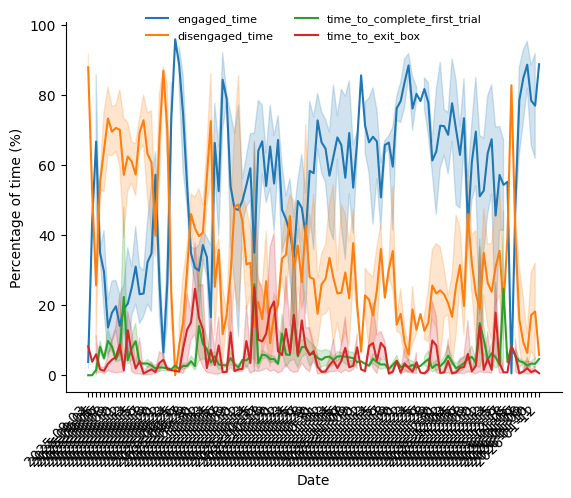

In [39]:
df = dft.add_trial_duration_column_to_df(df)
df = dft.add_engagement_column(df, engagement_sd_criteria=2)
sbu_df = dft.get_box_usage_df(df, events_df, verbose=False)
sbu_df = dft.add_day_column_to_df(sbu_df)
ax_eng = plots.plot_box_usage_by_date(sbu_df)

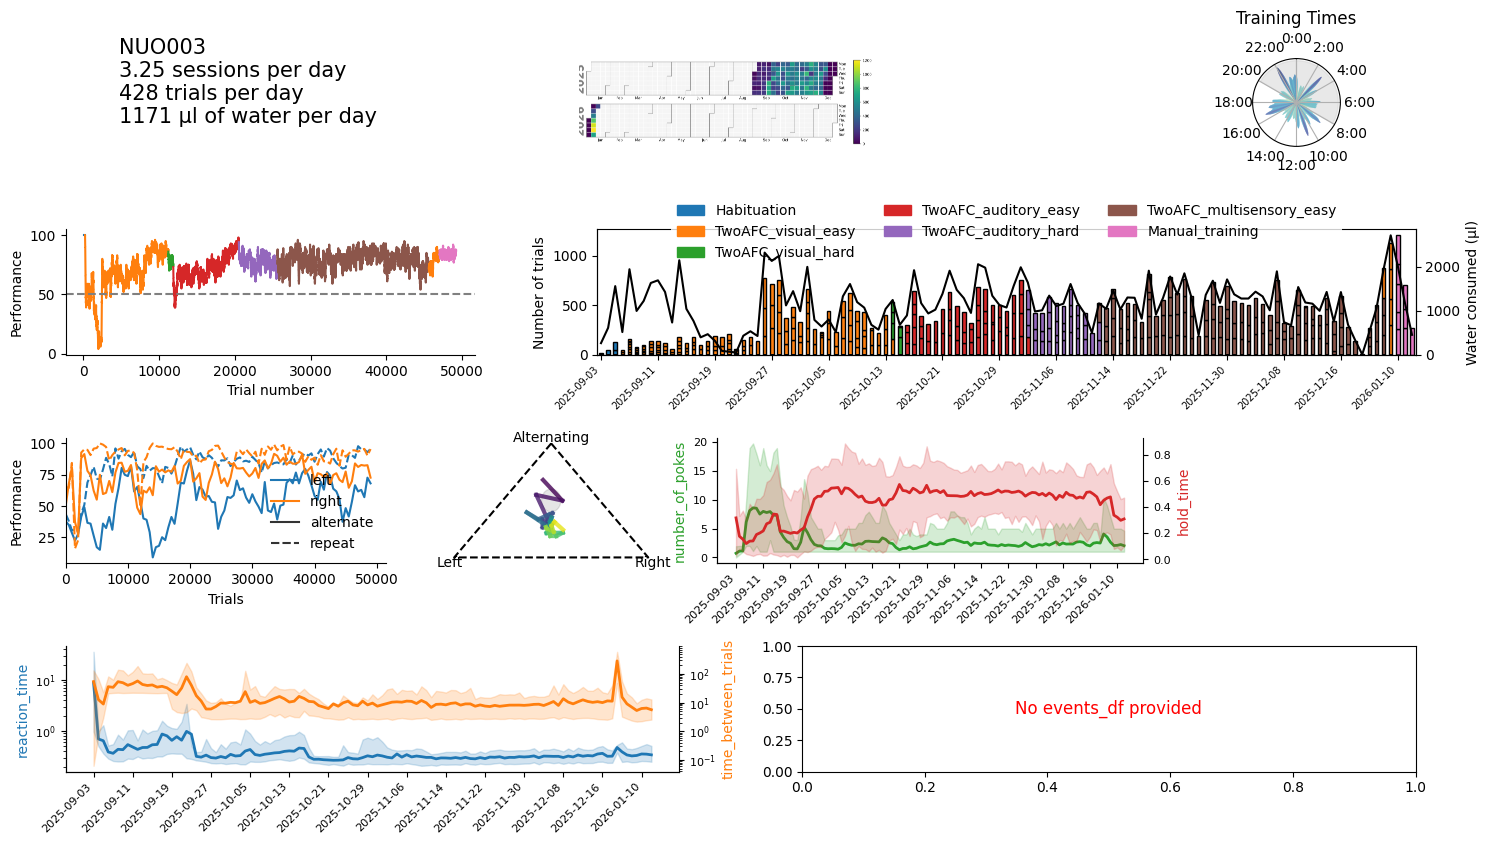

In [40]:
from lecilab_behavior_analysis.figure_maker import subject_progress_figure

fig = subject_progress_figure(df, perf_window=100, summary_matrix_plot=False)#, events_df=events_df)

(-0.5, 7499.5, 1019.5, -0.5)

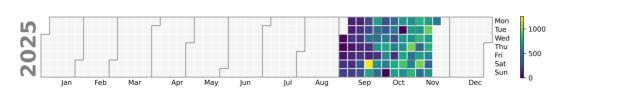

In [25]:
from lecilab_behavior_analysis import plots
import matplotlib.pyplot as plt
from lecilab_behavior_analysis import df_transforms as dft

dates_df = dft.get_dates_df(df)
fig, ax_cal = plt.subplots(figsize=(8, 4))
cal_image = plots.rasterize_plot(plots.training_calendar_plot(dates_df), dpi=600)
# paste the calendar plot filling the entire axis
ax_cal.imshow(cal_image)
ax_cal.axis("off")

/tmp/ipykernel_204725/666947774.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab10 = cm.get_cmap('tab10')


Text(0, 0.5, 'Performance (%)')

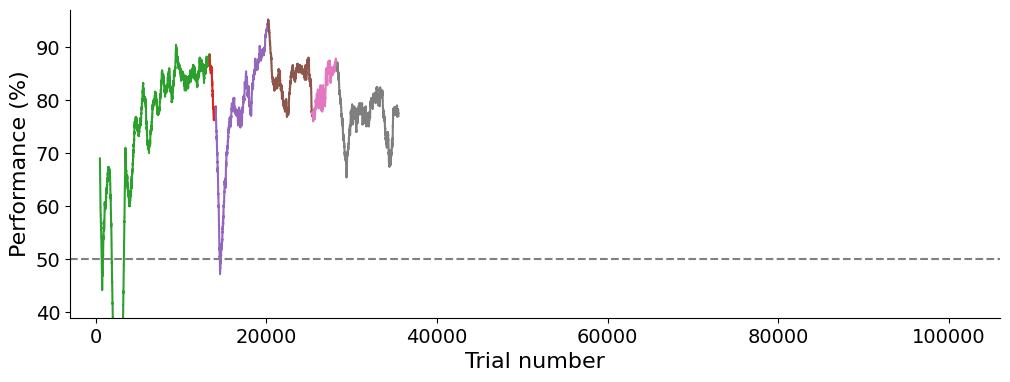

In [37]:

# fill information in df if it is missing
df = dft.fill_missing_data(df)

# add a column with the date for the day
df = dft.add_day_column_to_df(df)
df = dft.get_performance_through_trials(df, window=500)

#use the tab10 palette starting from color 2
import matplotlib.pyplot as plt
import matplotlib.cm as cm

tab10 = cm.get_cmap('tab10')
colors = [tab10(i) for i in range(1, 10)]

fig, ax = plt.subplots(figsize=(12, 4))
plots.performance_vs_trials_plot(df, ax=ax, legend=False, palette=colors)
# make the font size larger
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlim(-3000, 106000)
ax.set_ylim(39, 97)
ax.set_xlabel("Trial number", fontsize=16)
ax.set_ylabel("Performance (%)", fontsize=16)

In [8]:
df.current_training_stage.nunique()

8

In [ ]:
# # load the data if cluster is down
# mouse_path = utils.get_outpath() + "/visual_and_COT_data/sessions/ACV008/ACV008.csv"
# df = pd.read_csv(mouse_path, sep=";")

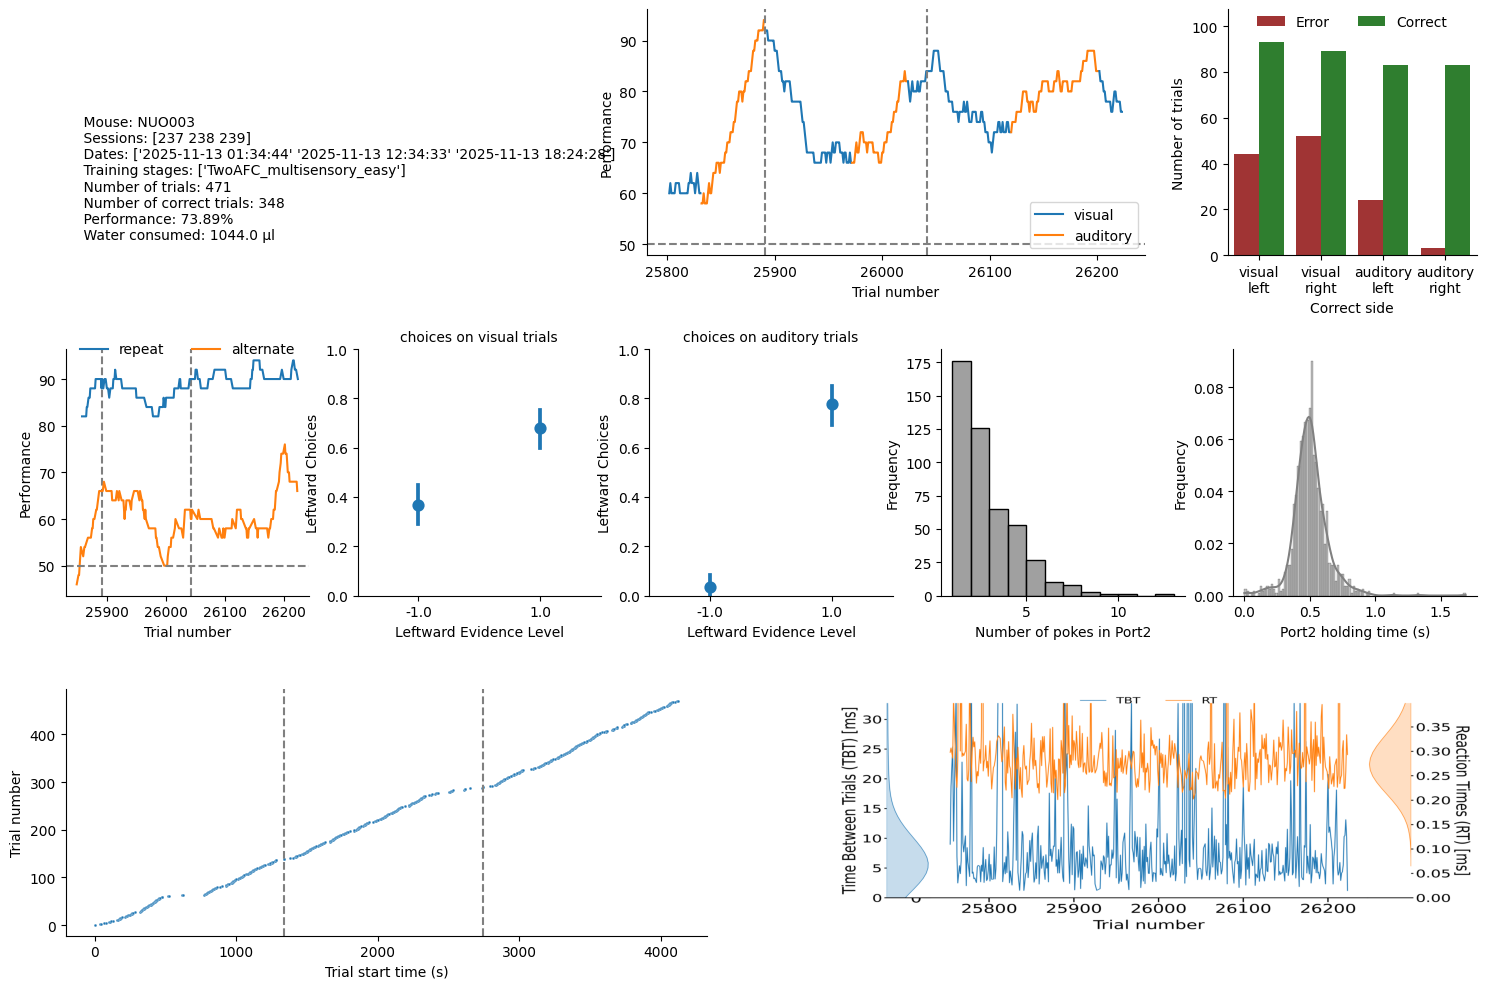

In [28]:
from lecilab_behavior_analysis.figure_maker import session_summary_figure
from lecilab_behavior_analysis.df_transforms import add_trial_of_day_column_to_df, add_day_column_to_df
import numpy as np
# select the session you want to plot
date = "2025-11-13"
# df = analyze_df(df)
df = add_day_column_to_df(df)
df = add_trial_of_day_column_to_df(df)
df['total_trial'] = np.arange(1, df.shape[0] + 1)
sdf = df[df["year_month_day"] == date]
# sdf = df[df["current_training_stage"] == "TwoAFC_auditory_hard"]
fig = session_summary_figure(sdf, perf_window=50)

In [ ]:
from lecilab_behavior_analysis import df_transforms as dft
from lecilab_behavior_analysis import utils
sdf = utils.add_time_from_session_start(sdf)

In [ ]:
sdf[sdf.session != sdf.session.shift(1)].index

In [ ]:
sdf = dft.adjust_trials_and_time_of_start_to_first_session(sdf)

In [ ]:
from lecilab_behavior_analysis import plots
# find the index of the session changes
session_changes = sdf[sdf.session != sdf.session.shift(1)].index
plots.plot_trial_time_of_start(sdf, session_changes=session_changes, width=15, height=10)